### Cell 1: Setup and imports

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / 'src'))

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from config.config import load_config
from simulation.simulator import MarketSimulator

# Set style for nice plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Environment setup complete!")

Environment setup complete!


### Cell 2: Load and Inspect Configuration

In [2]:
# Load configuration
config = load_config("../configs/default.yaml")

# Display key parameters
print("CONFIGURATION")
print(f"Market Maker:")
print(f"Initial Capital: ${config.market_maker.initial_capital:,.0f}")
print(f"Max Inventory: {config.market_maker.max_inventory}")
print(f"Base Spread: {config.market_maker.base_spread}")
print(f"Quote Levels: {config.market_maker.num_quote_levels}")

print(f"\nModels:")
print(f"Volatility: {'EGARCH' if config.models.garch.use_egarch else 'GARCH'}"
      f"({config.models.garch.p},{config.models.garch.q})")
print(f"Vol Target: {config.models.garch.vol_target}")
print(f"Microprice Levels: {config.models.microprice.depth_levels}")

print(f"\nSimulation:")
print(f"Duration: {config.simulation.ticks:,} ticks")
print(f"Random Seed: {config.simulation.random_seed}")

CONFIGURATION
Market Maker:
Initial Capital: $1,000,000
Max Inventory: 10000
Base Spread: 0.18
Quote Levels: 3

Models:
Volatility: EGARCH(1,1)
Vol Target: 0.15
Microprice Levels: 5

Simulation:
Duration: 10,000 ticks
Random Seed: 37


### Cell 3: Run Simulation

In [3]:
print("Starting simulation!")
simulator = MarketSimulator(config)
results = simulator.run()

Starting simulation!
Initializing market simulation...
Initializing market maker: MM_01
Initialized EGARCH(1,1) volatility model
Market maker initialized: MM_01
Simulation initialized with 14 participants

Starting simulation for 10000 ticks...
Initial price: 100.0
Market maker capital: 1000000.0
Tick 1000/10000
Price: 99.41 (Fair: 98.81)
Spread: 0.070
MM Position: -100
MM PnL: $1,219.63
Total trades: 4976

Tick 1100:
Price: 99.6500
Position: 100 @ $99.4900
PnL: $1349.61 (Realized: $1333.61, Unrealized: $16.00)
Volatility: 0.0000 (very_low)
Market toxicity: 0.2628
Toxic traders: 0
Pending adverse analyses: 0
Orders: {'buy': 3, 'sell': 3, 'total': 6}
Trades: 198
Fees: $0.88
Spread components: {'base': 1.0, 'volatility': 1, 'inventory': 1.005, 'adverse': 1.0, 'imbalance': 1.3599999999999999}
Tick 2000/10000
Price: 98.93 (Fair: 99.32)
Spread: 0.060
MM Position: -300
MM PnL: $2,656.87
Total trades: 10625

Tick 2100:
Price: 99.2650
Position: 300 @ $99.0600
PnL: $2856.84 (Realized: $2795.34,

### Cell 4: Convert Results to Dataframes

In [4]:
# Price and spread data
price_df = pd.DataFrame({
    'tick': range(len(results['price_history'])),
    'price': results['price_history'],
    'spread': results['spread_history'],
    'volume': results['volume_history'],
})

# Market maker metrics
mm_df = pd.DataFrame(results['mm_metrics_history'])

# Add returns for analysis
price_df['returns'] = price_df['price'].pct_change()
price_df['log_returns'] = np.log(price_df['price'] / price_df['price'].shift(1))

print(f"Data prepared: {len(price_df)} ticks")
print(f"Price range: ${price_df['price'].min():,.2f} - ${price_df['price'].max():,.2f}")

Data prepared: 10000 ticks
Price range: $97.66 - $101.56


### Cell 5: Visualize Price and PnL Evolution

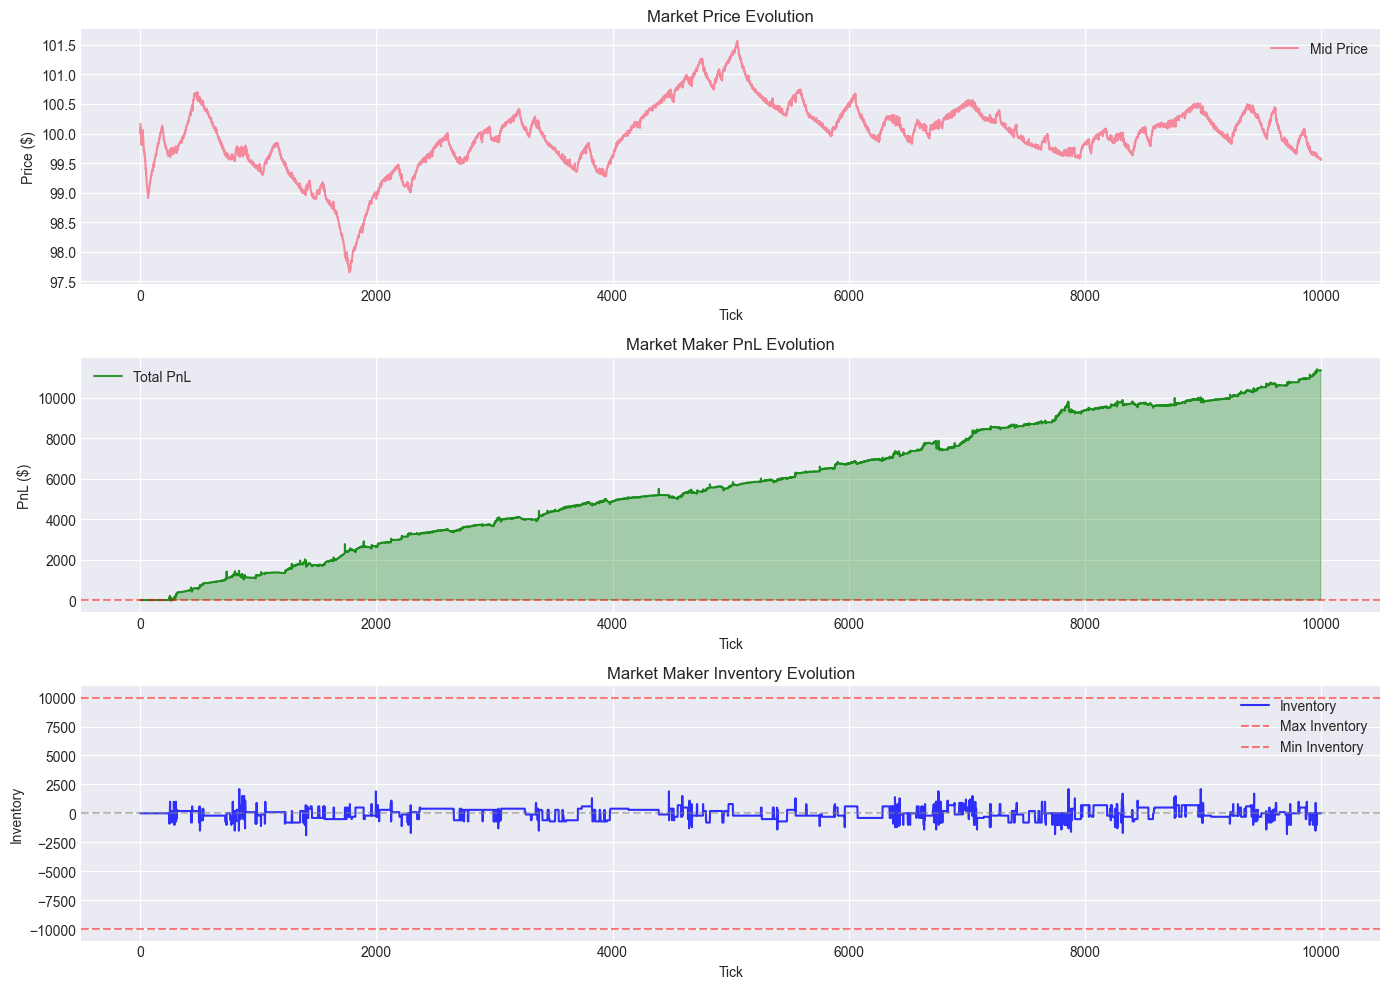

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Price evolution
ax1 = axes[0]
ax1.plot(price_df['tick'], price_df['price'], label='Mid Price', alpha=0.8)
ax1.set_xlabel('Tick')
ax1.set_ylabel('Price ($)')
ax1.set_title('Market Price Evolution')
ax1.legend()
ax1.grid(True)

# PnL evolution
ax2 = axes[1]
ax2.plot(mm_df['tick'], mm_df['pnl'], label='Total PnL', color='green', alpha=0.8)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.fill_between(mm_df['tick'], mm_df['pnl'], where=mm_df['pnl'] >= 0, color='green', alpha=0.3)
ax2.fill_between(mm_df['tick'], mm_df['pnl'], where=mm_df['pnl'] < 0, color='red', alpha=0.3)
ax2.set_xlabel('Tick')
ax2.set_ylabel('PnL ($)')
ax2.set_title('Market Maker PnL Evolution')
ax2.legend()
ax2.grid(True)

# Position evolution
ax3 = axes[2]
ax3.plot(mm_df['tick'], mm_df['position'], label='Inventory', color='blue', alpha=0.8)
ax3.axhline(y=0, color='grey', linestyle='--', alpha=0.5)
ax3.axhline(y=config.market_maker.max_inventory, color='red', linestyle='--', alpha=0.5, label='Max Inventory')
ax3.axhline(y=-config.market_maker.max_inventory, color='red', linestyle='--', alpha=0.5, label='Min Inventory')
ax3.set_xlabel('Tick')
ax3.set_ylabel('Inventory')
ax3.set_title('Market Maker Inventory Evolution')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

### Cell 6: Spread Analysis

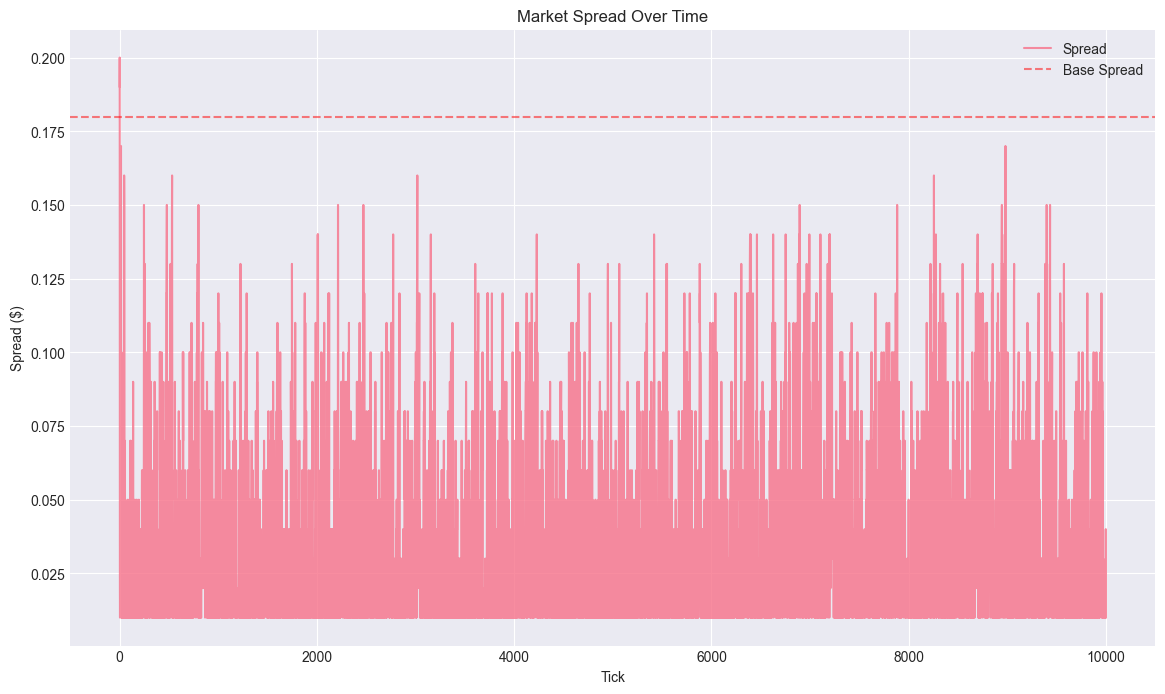

In [6]:
# Spread over time
plt.figure(figsize=(14, 8))
plt.plot(price_df['tick'], price_df['spread'], label='Spread', alpha=0.8)
plt.axhline(y=config.market_maker.base_spread, color='red', linestyle='--', alpha=0.5, label='Base Spread')
plt.xlabel('Tick')
plt.ylabel('Spread ($)')
plt.title('Market Spread Over Time')
plt.legend()
plt.grid(True)

### Cell 7: Performance metrics

In [7]:
# Calculate key metrics
final_metrics = results['final_mm_metrics']

# Sharpe ratio (simplified)
returns = mm_df['pnl'].diff()
sharpe = returns.mean() / returns.std() * np.sqrt(252 * 6.5 * 36) if returns.std() > 0 else 0

# Max drawdown
cummax = mm_df['pnl'].cummax()
drawdown = mm_df['pnl'] - cummax
max_drawdown = drawdown.min()

# Win rate
trade_returns = returns[returns != 0]
win_rate = (trade_returns > 0).sum() / len(trade_returns) * 100 if len(trade_returns) > 0 else 0

print("=== PERFORMANCE METRICS ===")
print(f"Total PnL: ${final_metrics['position']['total_pnl']:,.2f}")
print(f"- Realized: ${final_metrics['position']['realized_pnl']:,.2f}")
print(f"- Unrealized: ${final_metrics['position']['unrealized_pnl']:,.2f}")
print(f"Total Volume: {final_metrics['position']['total_volume']:,}")
print(f"Number of Trades: {final_metrics['position']['num_trades']}")
print(f"Avg PnL per Trade: ${final_metrics['position']['total_pnl']/max(1,final_metrics['position']['num_trades']):.2f}")
print(f"\nRisk Metrics:")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: ${max_drawdown:.2f}")
print(f"Win Rate: {win_rate:.1f}%")
print(f"\nModel Performance:")
print(f"GARCH Fits: {final_metrics['volatility']['fit_count']}")
print(f"Toxic Traders Identified: {final_metrics['adverse_selection']['num_toxic_traders']}")

=== PERFORMANCE METRICS ===
Total PnL: $11,348.14
- Realized: $11,348.14
- Unrealized: $0.00
Total Volume: 625,400
Number of Trades: 1375
Avg PnL per Trade: $8.25

Risk Metrics:
Sharpe Ratio: 12.06
Max Drawdown: $-599.79
Win Rate: 52.9%

Model Performance:
GARCH Fits: 99
Toxic Traders Identified: 0
